In [42]:
import os
import sys
sys.path.append(os.path.abspath("../.."))
sys.path.append(os.path.abspath("../../../../datasets"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from scipy import stats
from scipy import sparse

# metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import lightgbm as lgb

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import Normalizer


# NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import gensim

# 内存管理
import gc

# utils
from utils.data_logging import data_logging
# 内存优化
from utils.data_memory_optim import reduce_memory_usage
# feature stacking
from utils.FeatureStacking import stacking_clf
from utils.FeatureStacking import rf_clf, ada_clf, gb_clf, et_clf, xgb_clf, lgb_clf, gnb_clf, lr_clf, knn_clf

import warnings
warnings.filterwarnings("ignore")

# 1.背景介绍

## 1.1 问题背景

## 1.2 评估指标

- AUC(Area Under Curve)
    - $$AUC = \frac{\sum_{i \in positive Class} rank_{i} - \frac{M(1 + M)}{2}}{M \times N}$$
    - AUC 有两方面的含义
        - AUC 只反映模型对正负样本排序能力的强弱, 对 score 的大小和精度没有要求
        - AUC 越高, 模型排序能力越强. 理论上, 当模型把所有正样本都排在负样本之前时, AUC 为 1.0, 是理论的最大值 

# 2.数据探索

## 2.1 数据读取

In [2]:
data_path = "../../../../datasets/tmall_repurchase_predict/data_format1/"
# 用户行为日志
user_log = pd.read_csv(os.path.join(data_path, "user_log_format1.csv"), encoding = "utf-8")#.rename(columns = {"seller_id": "merchant_id"})
# 用户特征数据
user_info = pd.read_csv(os.path.join(data_path, "user_info_format1.csv"), encoding = "utf-8")#.drop_duplicates()
# 训练数据
train_data = pd.read_csv(os.path.join(data_path, "train_format1.csv"), encoding = "utf-8")
# 测试数据
test_data = pd.read_csv(os.path.join(data_path, "test_format1.csv"), encoding = "utf-8")

## 2.2 数据探索

In [3]:
print(data_logging(user_log, "user_log"))
print("-" * 100)
print(data_logging(user_info, "user_info"))
print("-" * 100)
print(data_logging(train_data, "train_data"))
print("-" * 100)
print(data_logging(test_data, "test_data"))

user_log.head()
   user_id  item_id  cat_id  seller_id  brand_id  time_stamp  action_type
0   328862   323294     833       2882    2661.0         829            0
1   328862   844400    1271       2882    2661.0         829            0
2   328862   575153    1271       2882    2661.0         829            0
3   328862   996875    1271       2882    2661.0         829            0
4   328862  1086186    1271       1253    1049.0         829            0
user_log.tail()
          user_id  item_id  cat_id  seller_id  brand_id  time_stamp  \
54925325   208016   107662     898       1346    7995.0        1110   
54925326   208016  1058313     898       1346    7995.0        1110   
54925327   208016   449814     898        983    7995.0        1110   
54925328   208016   634856     898       1346    7995.0        1110   
54925329   208016   272094     898       1346    7995.0        1111   

          action_type  
54925325            0  
54925326            0  
54925327            0  
5

## 2.3 查看缺失值

### 2.3.1 查看用户特征信息数据缺失情况

#### 2.3.1.1 查看用户特征信息数据缺失情况

In [14]:
user_info.isna().sum()

user_id         0
age_range    2217
gender       6436
dtype: int64

#### 2.3.1.2 查看用户特征信息年龄数据缺失情况

In [15]:
(user_info.shape[0] - user_info["age_range"].count()) / user_info.shape[0]

0.005226677982884221

In [25]:
user_info[user_info["age_range"].isna() | (user_info["age_range"] == 0)].count()#["age_range"].count()

user_id      95131
age_range    92914
gender       90664
dtype: int64

In [17]:
user_info.groupby(["age_range"])[["user_id"]].count()

,user_id
age_range,
0.0,92914
1.0,24
2.0,52871
3.0,111654
4.0,79991
5.0,40777
6.0,35464
7.0,6992
8.0,1266


#### 2.3.1.3 查看用户特征信息性别数据缺失情况

In [18]:
(user_info.shape[0] - user_info["gender"].count()) / user_info.shape[0]

0.01517316170403376

In [19]:
user_info[user_info["gender"].isna() | (user_info["gender"] == 2)].count()#["gender"].count()

user_id      16862
age_range    14664
gender       10426
dtype: int64

In [20]:
user_info.groupby(["gender"])[["user_id"]].count()

,user_id
gender,
0.0,285638
1.0,121670
2.0,10426


#### 2.3.1.4 查看用户特征信息年龄或性别数据缺失情况

In [21]:
user_info[user_info["age_range"].isna() | (user_info["age_range"] == 0) | user_info["gender"].isna() | (user_info["gender"] == 2)].count()

user_id      106330
age_range    104113
gender        99894
dtype: int64

### 2.3.2 查看用户行为日志数据缺失情况

In [22]:
user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

### 2.3.3 查看训练数据缺失情况

In [23]:
train_data.isna().sum()

user_id        0
merchant_id    0
label          0
dtype: int64

### 2.3.4 查看测试数据缺失情况

In [24]:
test_data.isna().sum()

user_id             0
merchant_id         0
prob           261477
dtype: int64

## 2.4 观察数据分布

### 2.4.1 查看整体数据统计信息

In [20]:
print(user_log.describe())
print("-" * 50)
print(user_info.describe())
print("-" * 50)
print(train_data.describe())
print("-" * 50)
print(test_data.describe())

            user_id       item_id        cat_id     seller_id      brand_id  \
count  5.492533e+07  5.492533e+07  5.492533e+07  5.492533e+07  5.483432e+07   
mean   2.121568e+05  5.538613e+05  8.770308e+02  2.470941e+03  4.153348e+03   
std    1.222872e+05  3.221459e+05  4.486269e+02  1.473310e+03  2.397679e+03   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.063360e+05  2.731680e+05  5.550000e+02  1.151000e+03  2.027000e+03   
50%    2.126540e+05  5.555290e+05  8.210000e+02  2.459000e+03  4.065000e+03   
75%    3.177500e+05  8.306890e+05  1.252000e+03  3.760000e+03  6.196000e+03   
max    4.241700e+05  1.113166e+06  1.671000e+03  4.995000e+03  8.477000e+03   

         time_stamp   action_type  
count  5.492533e+07  5.492533e+07  
mean   9.230953e+02  2.854458e-01  
std    1.954305e+02  8.075806e-01  
min    5.110000e+02  0.000000e+00  
25%    7.300000e+02  0.000000e+00  
50%    1.010000e+03  0.000000e+00  
75%    1.109000e+03  0.000000e+00  


### 2.4.2 查看正负样本的分布

In [10]:
# 方法1
label_gp = train_data.groupby("label")["user_id"].count()
print("正负样本的数量: \n", label_gp)

# 方法2
# label_gp = train_data.label.value_counts()
# print("正负样本的数量: \n", label_gp)

正负样本的数量: 
 label
0    244912
1     15952
Name: user_id, dtype: int64


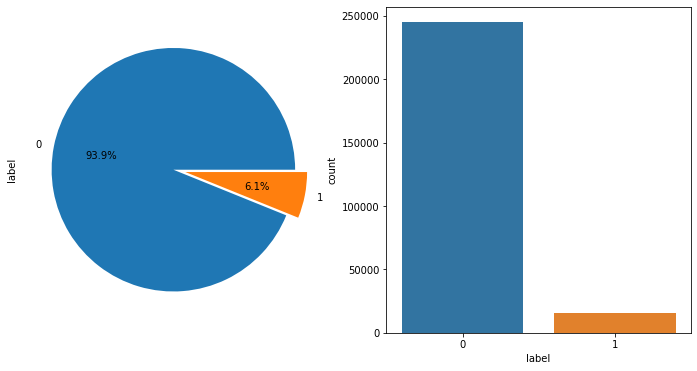

In [11]:
_, axe = plt.subplots(1, 2, figsize = (12, 6))
train_data.label.value_counts() \
    .plot(kind = "pie", autopct = "%1.1f%%", shadow = False, explode = [0, 0.1], ax = axe[0])
sns.countplot("label", data = train_data, ax = axe[1]);

## 2.5 探查影响复购的各种因素

### 2.5.1 对店铺的分析

#### 2.5.1.1 分析不同店铺与复购的关系

In [23]:
print("选取top5店铺:\n-------------\n店铺\t购买次数")
print(train_data.merchant_id.value_counts().head(5))

选取top5店铺:
-------------
店铺	购买次数
4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64


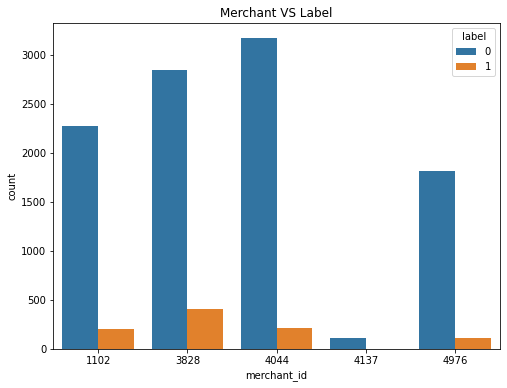

In [24]:
train_data_merchant = train_data.copy()
train_data_merchant["TOP5"] = train_data_merchant["merchant_id"].map(lambda x: 1 if x in [4044, 3828, 4137, 1102, 4976] else 0)
train_data_merchant = train_data_merchant[train_data_merchant["TOP5"] == 1]
plt.figure(figsize = (8, 6))
plt.title("Merchant VS Label")
sax = sns.countplot("merchant_id", hue = "label", data = train_data_merchant)

#### 2.5.1.2 查看店铺的复购分布

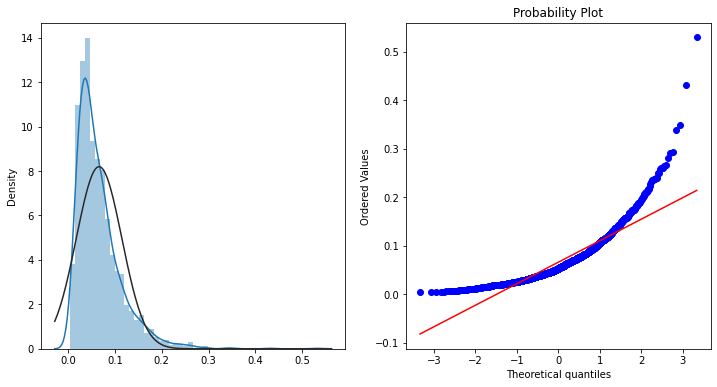

In [25]:
merchant_repeat_buy = [rate for rate in train_data.groupby("merchant_id")["label"].mean() if rate > 0 and rate <= 1]
plt.figure(figsize = (12, 6))
ax = plt.subplot(1, 2, 1)
sns.distplot(merchant_repeat_buy, fit = stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(merchant_repeat_buy, plot = plt)

### 2.5.2 对用户的分析

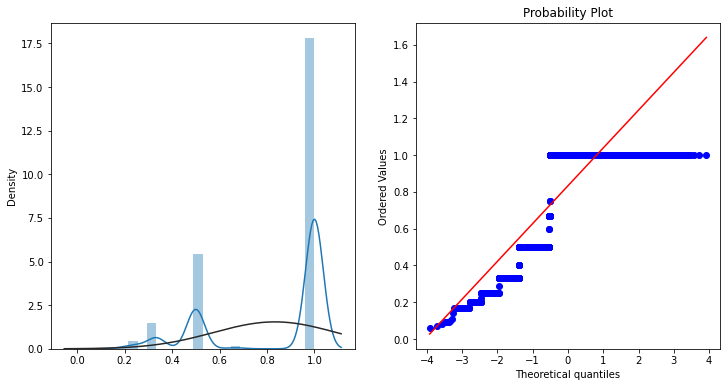

In [26]:
user_repeat_buy = [rate for rate in train_data.groupby("user_id")["label"].mean() if rate > 0 and rate <= 1]
plt.figure(figsize = (12, 6))
ax = plt.subplot(1, 2, 1)
sns.distplot(user_repeat_buy, fit = stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(user_repeat_buy, plot = plt)

### 2.5.3 对用户性别的分析

In [27]:
train_data_user_info = train_data.merge(user_info, on = ["user_id"], how = "left")
train_data_user_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 0 to 260863
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      260864 non-null  int64  
 1   merchant_id  260864 non-null  int64  
 2   label        260864 non-null  int64  
 3   age_range    259611 non-null  float64
 4   gender       257153 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 11.9 MB


#### 2.5.3.1 分析用户性别与复购的关系

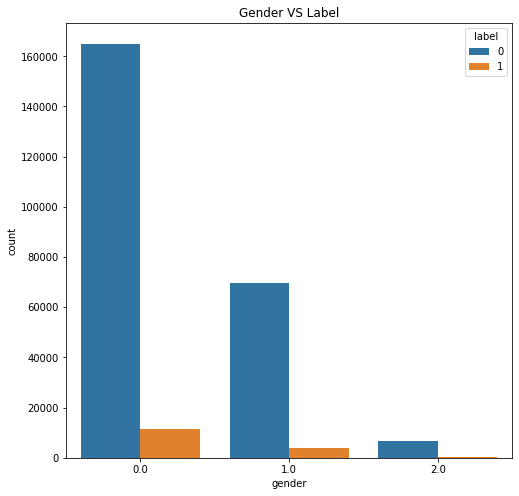

In [28]:
plt.figure(figsize = (8, 8))
plt.title("Gender VS Label")
ax = sns.countplot("gender", hue = "label", data = train_data_user_info)

#### 2.5.3.2 查看用户性别复购的分布

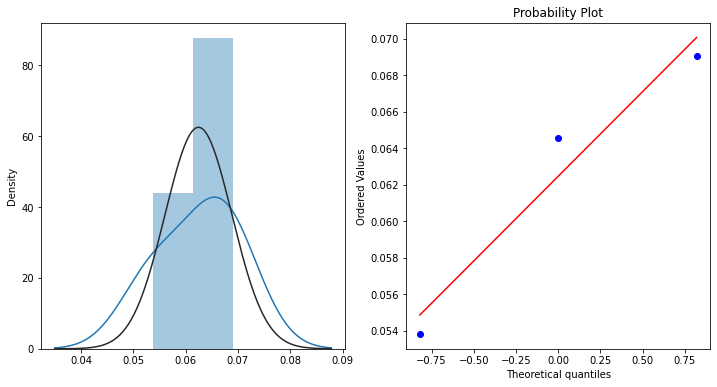

In [29]:
gender_repeat_buy = [rate for rate in train_data_user_info.groupby(["gender"])["label"].mean()]
plt.figure(figsize = (12, 6))
ax = plt.subplot(1, 2, 1)
sns.distplot(gender_repeat_buy, fit = stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(gender_repeat_buy, plot = plt)

### 2.5.4 对用户年龄的分析

#### 2.5.4.1 分析用户年龄与复购的关系

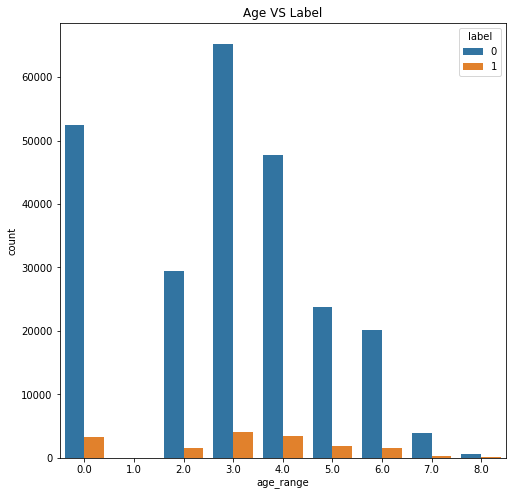

In [30]:
plt.figure(figsize = (8, 8))
plt.title("Age VS Label")
ax = sns.countplot("age_range", hue = "label", data = train_data_user_info)

#### 2.5.4.2 查看用户年龄复购的分布

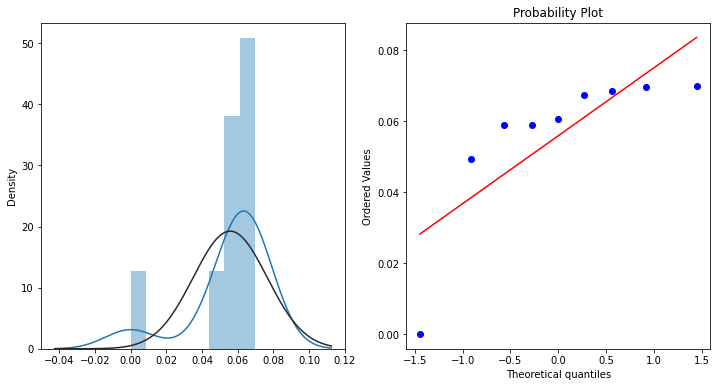

In [31]:
age_repeat_buy = [rate for rate in train_data_user_info.groupby(["age_range"])["label"].mean()]
plt.figure(figsize = (12, 6))
ax = plt.subplot(1, 2, 1)
sns.distplot(age_repeat_buy, fit = stats.norm)
ax = plt.subplot(1, 2, 2)
res = stats.probplot(age_repeat_buy, plot = plt)

# 3.特征工程

## 3.1 对数据进行内存压缩

In [26]:
user_log = reduce_memory_usage(user_log)
user_info = reduce_memory_usage(user_info)
trian_data = reduce_memory_usage(train_data)
test_data = reduce_memory_usage(test_data)

Memory usage before optimization is: 2933.3292 MB
Memory usage after optimization is: 890.4750 MB
Memory decreased by 69.6%
Memory usage before optimization is: 9.7086 MB
Memory usage after optimization is: 3.2363 MB
Memory decreased by 66.7%
Memory usage before optimization is: 5.9708 MB
Memory usage after optimization is: 1.7416 MB
Memory decreased by 70.8%
Memory usage before optimization is: 5.9849 MB
Memory usage after optimization is: 3.4912 MB
Memory decreased by 41.7%


In [33]:
print(user_log.info())
print("-" * 50)
print(user_info.info())
print("-" * 50)
print(train_data.info())
print("-" * 50)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int32  
 1   item_id      int32  
 2   cat_id       int16  
 3   seller_id    int16  
 4   brand_id     float16
 5   time_stamp   int16  
 6   action_type  int8   
dtypes: float16(1), int16(3), int32(2), int8(1)
memory usage: 890.5 MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int32  
 1   age_range  421953 non-null  float16
 2   gender     417734 non-null  float16
dtypes: float16(2), int32(1)
memory usage: 3.2 MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 colu

## 3.2 数据处理

### 3.2.1 合并用户信息

In [34]:
all_data = train_data.append(test_data)
all_data = all_data.merge(user_info, on = ["user_id"], how = "left")

In [35]:
all_data.head()

,user_id,merchant_id,label,prob,age_range,gender
0,34176,3906,0.0,NaN,6.0,0.0
1,34176,121,0.0,NaN,6.0,0.0
2,34176,4356,1.0,NaN,6.0,0.0
3,34176,2217,0.0,NaN,6.0,0.0
4,230784,4818,0.0,NaN,0.0,0.0


In [36]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      522341 non-null  int32  
 1   merchant_id  522341 non-null  int16  
 2   label        260864 non-null  float64
 3   prob         0 non-null       float64
 4   age_range    519763 non-null  float16
 5   gender       514796 non-null  float16
dtypes: float16(2), float64(2), int16(1), int32(1)
memory usage: 16.9 MB


In [37]:
# 删除数据并回收内存
del train_data, test_data, user_info
gc.collect()

10760

### 3.2.2 将用户行为日志信息按时间进行排序

In [38]:
# 对每个用户逐个合并所有字段, 合并字段为 item_id
list_join_func = lambda x: " ".join([str(i) for i in x])
agg_dict = {
    "item_id": list_join_func,
    "cat_id": list_join_func,
    "seller_id": list_join_func,
    "brand_id": list_join_func,
    "time_stamp": list_join_func,
    "action_type": list_join_func,
}
rename_dict = {
    "item_id": "item_path",
    "cat_id": "cat_path",
    "seller_id": "seller_path",
    "brand_id": "brand_path",
    "time_stamp": "time_stamp_path",
    "action_type": "action_type_path",
}
def merge_list(df_ID, join_columns, df_data, agg_dict, rename_dict):
    df_data = df_data. \
        groupby(join_columns). \
        agg(agg_dict). \
        reset_index(). \
        rename(columns = rename_dict)
    df_ID = df_ID.merge(df_data, on = join_columns, how = "left")
    return df_ID

In [39]:
user_log = user_log.sort_values(["user_id", "time_stamp"])
all_data = merge_list(all_data, "user_id", user_log, agg_dict, rename_dict)

In [40]:
all_data.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...


In [41]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           522341 non-null  int32  
 1   merchant_id       522341 non-null  int16  
 2   label             260864 non-null  float64
 3   prob              0 non-null       float64
 4   age_range         519763 non-null  float16
 5   gender            514796 non-null  float16
 6   item_path         522341 non-null  object 
 7   cat_path          522341 non-null  object 
 8   seller_path       522341 non-null  object 
 9   brand_path        522341 non-null  object 
 10  time_stamp_path   522341 non-null  object 
 11  action_type_path  522341 non-null  object 
dtypes: float16(2), float64(2), int16(1), int32(1), object(6)
memory usage: 40.8+ MB


In [42]:
# 删除数据并回收内存
del user_log
gc.collect()

66

## 3.5 提取统计特征

### 3.5.1 特征统计

In [43]:
# 定义特征统计函数
def cnt_(x):
    """
    统计数据总数的函数
    """
    try:
        return len(x.split(" "))
    except:
        return -1


def nunique_(x):
    """
    统计数据中唯一值总数的函数
    """
    try:
        return len(set(x.split(" ")))
    except:
        return -1


def max_(x):
    """
    统计数据最大值的函数
    """
    try:
        return np.max([float(i) for i in x.split(" ")])
    except:
        return -1
    
    
def min_(x):
    """
    统计数据最小值的函数
    """
    try:
        return np.min([float(i) for i in x.split(" ")])
    except:
        return -1


def std_(x):
    """
    统计数据标准差
    """
    try:
        return np.std([float(i) for i in x.split(" ")])
    except:
        return -1


def most_n(x, n):
    """
    统计数据中 top N 数据
    """
    try:
        return Counter(x.split(" ")).most_common(n)[n - 1][0]
    except:
        return -1
    

def most_n_cnt(x, n):
    """
    统计数据中 top N 数据总数
    """
    try:
        return Counter(x.split(" ")).most_common(n)[n-1][1]
    except:
        return -1

In [44]:
# 调用特征统计函数
def user_cnt(data, single_col, name):
    data[name] = data[single_col].apply(cnt_)
    return data


def user_nunique(data, single_col, name):
    data[name] = data[single_col].apply(nunique_)
    return data


def user_max(data, single_col, name):
    data[name] = data[single_col].apply(max_)
    return data


def user_min(data, single_col, name):
    data[name] = data[single_col].apply(min_)
    return data


def user_std(data, single_col, name):
    data[name] = data[single_col].apply(std_)
    return data


def user_most_n(data, single_col, name, n = 1):
    func = lambda x: most_n(x, n)
    data[name] = data[single_col].apply(func)
    return data


def user_most_n_cnt(data, single_col, name, n = 1):
    func = lambda x: most_n_cnt(x, n)
    data[name] = data[single_col].apply(func)
    return data

In [45]:
# 1.店铺特征统计: 统计与店铺特点有关的特征, 如店铺、商品、品牌
all_data_test = all_data.head(2000)
# all_data_test = all_data

# 1.1 统计用户点击、浏览、加购、购买行为
# 总次数
all_data_test = user_cnt(all_data_test, "seller_path", "user_cnt")
# 不同店铺个数
all_data_test = user_nunique(all_data_test, "seller_path", "seller_nunique")
# 不同品类个数
all_data_test = user_nunique(all_data_test, "cat_path", "cat_nunique")
# 不同品牌个数
all_data_test = user_nunique(all_data_test, "brand_path", "brand_nunique")
# 不同商品个数
all_data_test = user_nunique(all_data_test, "item_path", "item_nunique")
# 活跃个数
all_data_test = user_nunique(all_data_test, "time_stamp_path", "time_stamp_nunique")
# 不同用户行为种数
all_data_test = user_nunique(all_data_test, "action_type_path", "action_type_nunique")
# 最晚时间
all_data_test = user_max(all_data_test, "action_type_path", "time_stamp_max")
# 最早时间
all_data_test = user_min(all_data_test, "action_type_path", "time_stamp_min")
# 活跃天数方差
all_data_test = user_std(all_data_test, "action_type_path", "time_stamp_std")
# 最早和最晚相差天数
all_data_test["time_stamp_range"] = all_data_test["time_stamp_max"] - all_data_test["time_stamp_min"]
# 用户最喜欢的店铺
all_data_test = user_most_n(all_data_test, "seller_path", "seller_most_1", n = 1)
# 用户最喜欢的类目
all_data_test = user_most_n(all_data_test, "cat_path", "cat_most_1", n = 1)
# 用户最喜欢的品牌
all_data_test = user_most_n(all_data_test, "brand_path", "brand_most_1", n = 1)
# 最常见的行为动作
all_data_test = user_most_n(all_data_test, "action_type_path", "action_type_1", n = 1)
# 用户最喜欢的店铺 行为次数
all_data_test = user_most_n_cnt(all_data_test, "seller_path", "seller_most_1_cnt", n = 1)
# 最喜欢的类目 行为次数
all_data_test = user_most_n_cnt(all_data_test, "cat_path", "cat_most_1_cnt", n = 1)
# 最喜欢的品牌 行为次数
all_data_test = user_most_n_cnt(all_data_test, "brand_path", "brand_most_1_cnt", n = 1)
# 最常见的行为动作 行为次数
all_data_test = user_most_n_cnt(all_data_test, "action_type_path", "action_type_most_1_cnt", n = 1)

In [46]:
# 2.用户特征统计: 对用户的点击、加购、购买、收藏等特征进行统计
# 对点击、加购、购买、收藏分开统计
def col_cnt_(data, columns_list, action_type):
    try:
        data_dict = {}
        col_list = copy.deepcopy(columns_list)
        if action_type != None:
            col_list += ["action_type_path"]
        for col in col_list:
            data_dict[col] = df_data[col].split(" ")
        path_len = len(data_dict[col])
        data_out = []
        for i_ in range(path_len):
            data_txt = ""
            for col_ in columns_list:
                if data_dict["action_type_path"][i_] == action_type:
                    data_txt += "_" + data_dict[col_][i_]
            data_out.append(data_txt)
        return len(data_out)
    except:
        return -1


def col_nunique_(data, columns_list, action_type):
    try:
        data_dict = {}
        col_list = copy.deepcopy(columns_list)
        if action_type != None:
            col_list += ["action_type_path"]
        for col in col_list:
            data_dict[col] = df_data[col].split(" ")
        path_len = len(data_dict[col])
        data_out = []
        for i_ in range(path_len):
            data_txt = ""
            for col_ in columns_list:
                if data_dict["action_type_path"][i_] == action_type:
                    data_txt += "_" + data_dict[col_][i_]
            data_out.append(data_txt)
        return len(set(data_out))
    except:
        return -1


def user_col_cnt(data, columns_list, action_type, name):
    data[name] = data.apply(lambda x: col_cnt_(x, columns_list, action_type), axis = 1)
    return data


def user_col_nunique(data, columns_list, action_type, name):
    data[name] = data.apply(lambda x: col_nunique_(x, columns_list, action_type), axis = 1)
    return data

In [47]:
# 3.统计用户和店铺的关系: 对店铺的用户点击次数、加购次数、购买次数、收藏次数等进行统计
# 3.1 点击次数
all_data_test = user_col_cnt(all_data_test, ["seller_path"], "0", "user_cnt_0")
# 3.2 加购次数
all_data_test = user_col_cnt(all_data_test, ["seller_path"], "1", "user_cnt_1")

### 3.5.2 特征组合

In [48]:
# 点击次数
all_data_test = user_col_cnt(all_data_test, ["seller_path", "item_path"], "0", "user_cnt_0")
# 不同店铺数
all_data_test = user_col_nunique(all_data_test, ["seller_path", "item_path"], "0", "seller_nunique_0")
all_data_test.columns

Index(['user_id', 'merchant_id', 'label', 'prob', 'age_range', 'gender',
       'item_path', 'cat_path', 'seller_path', 'brand_path', 'time_stamp_path',
       'action_type_path', 'user_cnt', 'seller_nunique', 'cat_nunique',
       'brand_nunique', 'item_nunique', 'time_stamp_nunique',
       'action_type_nunique', 'time_stamp_max', 'time_stamp_min',
       'time_stamp_std', 'time_stamp_range', 'seller_most_1', 'cat_most_1',
       'brand_most_1', 'action_type_1', 'seller_most_1_cnt', 'cat_most_1_cnt',
       'brand_most_1_cnt', 'action_type_most_1_cnt', 'user_cnt_0',
       'user_cnt_1', 'seller_nunique_0'],
      dtype='object')

## 3.6 利用 Countvector 和 TF-IDF 提取特征

In [49]:
tfidfVec = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range = (1, 1), max_features = 100)
columns_list = ["seller_path"]
for i, col in enumerate(columns_list):
    tfidfVec.fit(all_data_test[col])
    data_ = tfidfVec.transform(all_data_test[col])
    if i == 0:
        data_cat = data_
    else:
        data_cat = sparse.hstack((data_cat, data_))
        
df_tfidf = pd.DataFrame(data_cat.toarray())
df_tfidf.columns = ["tfidf_" + str(i) for i in df_tfidf.columns]
all_data_test = pd.concat([all_data_test, df_tfidf], axis = 1)

## 3.7 嵌入特征

In [50]:
model = gensim.models.Word2Vec(
    all_data_test["seller_path"].apply(lambda x: x.split(" ")),
    size = 100,
    window = 5,
    min_count = 5,
    workers = 4
)
# model.save("product2vec.model")
# model = gensim.models.Word2Vec.load("product2vec.model")


def mean_w2v_(x, model, size = 100):
    """
    
    """
    try:
        i = 0
        for word in x.split(" "):
            if word in model.wv.vocab:
                i += 1
                if i == 1:
                    vec = np.zeros(size)
                vec += model.wv[word]
        return vec / i
    except:
        return np.zeros(size)
    

def get_mean_w2v(data, columns, model, size):
    """
    
    """
    data_array = []
    for index, row in data.iterrows():
        w2v = mean_w2v_(row[columns], model, size)
        data_array.append(w2v)
    return pd.DataFrame(data_array)


df_embeeding = get_mean_w2v(all_data_test, "seller_path", model, 100)
df_embeeding.columns = ["embeeding_" + str(i) for i in df_embeeding.columns]
all_data_test = pd.concat([all_data_test, df_embeeding], axis = 1)

## 3.8 Stacking 分类特征

### 3.8.1 定义 Stacking 分类特征相关函数

### 3.8.2 读取训练数据和验证数据

In [51]:
features_columns = [c for c in all_data_test.columns if c not in ["label", "prob", "seller_path", "cat_path", "brand_path", "action_type_path", "item_path", "time_stamp_path"]]
x_train = all_data_test[~all_data_test["label"].isna()][features_columns].values
y_train = all_data_test[~all_data_test["label"].isna()]["label"].values
x_valid = all_data_test[all_data_test["label"].isna()][features_columns].values

In [52]:
def get_matrix(data):
    where_are_nan = np.isnan(data)
    where_are_inf = np.isinf(data)
    data[where_are_nan] = 0
    data[where_are_inf] = 0
    return data

x_train = np.float_(get_matrix(np.float_(x_train)))
y_train = np.int_(y_train)
x_valid = x_train

### 3.8.3 使用 lgb 和 xgb 分类模型构造 Stacking 特征

In [27]:
# 1.使用5折交叉验证
folds =5 
seed = 1
# 2.选择lgb和xgb分类模型作为基模型
clf_list = [lgb_clf, xgb_clf]
clf_list_col = ["lgb_clf", "xgb_clf"]
# 3.获取Stacking特征
clf_list = clf_list
column_list = []
train_data_list = []
test_data_list = []
for clf in clf_list:
    train_data, test_data, clf_name = clf(x_train, y_train, x_valid, folds, label_split = None)
    train_data_list.append(train_data)
    test_data_list.append(test_data)
train_stacking = np.concatenate(train_data_list, axis = 1)
test_stacking = np.concatenate(test_data_list, axis = 1)

### 3.8.4 原始特征和 Stacking 特征合并

In [ ]:
train = pd.DataFrame(np.concatenate([x_train, train_stacking], axis = 1))
test = np.concatenate([x_valid, test_stacking], axis = 1)
df_train_all = pd.DataFrame(train)
df_train_all.columns = feature_columns + clf_list_col
df_test_all = pd.DataFrame(test)
df_test_all.columns = features_columns + clf_list_col
df_train_all["user_id"] = all_data_test[~all_data_test["label"].isna()]["user_id"]
df_train_all["label"] = all_data_test[~all_data_test["label"].isna()]["label"]
df_test_all["user_id"] = all_data_test[all_data_test["label"].isna()]["user_id"]

df_train_all.to_csv("train_all.csv", header = True, index = False)
df_test_all.to_csv("test_all.csv", header = True, index = False)

# 4.模型训练

# 5.模型验证

In [ ]:
# data
train_data = pd.read_csv("train_all.csv")
test_data = pd.read_csv("test_all.csv")

features_columns = [col for col in train_data.columns if col not in ["user_id", "label"]]
train = train_data[features_columns].values
test = test_data[features_columns].values
target = train_dasta["label"].values

# train and test split


# 6.特征优化

In [ ]:
# data
train_data = pd.read_csv("train_all.csv")
test_data = pd.read_csv("test_all.csv")

features_columns = [col for col in train_data.columns if col not in ["user_id", "label"]]
train = train_data[features_columns].values
test = test_data[features_columns].values
target = train_dasta["label"].values

## 6.2 缺失值填充

In [31]:
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
imputer = imputer.fit(train)
train_imputer = imputer.transform(train)
test_imputer = imputer.transform(test)

## 6.3 特征选择

In [33]:
def feature_selection(train, train_sel, target):
    clf = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 0, n_jobs = -1)
    scores = cross_val_score(clf, train, target, cv = 5)
    scores_sel = cross_val_score(clf, train_sel, target, cv = 5)
    print("No Select Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Features Select Accuracy: %0.2f (+/- %0.2f)" % (scores_sel.mean(), scores_sel.std() * 2))

### 6.3.1 删除方差较小的特征

In [ ]:
sel = VarianceThreshold(threshold = (0.8 * (1 - 0.8)))
sel = sel.fit(train)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print("训练数据未特征筛选维度: ", train.shape)
print("训练数据特征筛选维度后: ", train_sel.shape)

In [36]:
# 特征选择前后对比
feature_selection(train, train_sel, target)

### 6.3.2 单变量特征选择

In [ ]:
sel = SelectKBest(mutual_info_classif, k = 2)
sel = sel.fit(train, target)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print("训练数据未特征筛选维度: ", train.shape)
print("训练数据特征筛选维度后: ", train_sel.shape)

### 6.3.3 递归功能消除

In [ ]:
clf = RandomForestClassifier(n_estimators = 10, max_depth = 2, random_state = 0, n_jobs = -1)
selector = RFECV(clf, step = 1, cv = 2)
selector = selector.fit(train, target)
print(selector.support_)
print(selector.ranking_)

### 6.3.4 使用模型选择特征

In [ ]:
normalizer = Normalizer()
normalizer = normalizer.fit(train)
train_norm = normalizer.transform(train)
test_norm = normalizer.transform(test)

#### 6.3.4.1 L2 范数特征选择

In [ ]:
LR = LogisticRegression(penalty = "l2", C = 5)
LR = LR.fit(tranin_norm, target)
model = SelectFromModel(LR, prefit = True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print("训练数据未特征筛选维度: ", train.shape)
print("训练数据特征筛选维度后: ", train_sel.shape)

In [ ]:
# L2 范数选择参数
LR.coef_[0][:10]

In [ ]:
# 特征选择前后对比
feature_selection(train, train_sel, target)

#### 6.3.4.2 L1 范数特征选择

In [ ]:
LR = LogisticRegression(penalty = "l1", C = 5)
LR = LR.fit(tranin_norm, target)
model = SelectFromModel(LR, prefit = True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print("训练数据未特征筛选维度: ", train.shape)
print("训练数据特征筛选维度后: ", train_sel.shape)

In [ ]:
# L1 范数选择参数
LR.coef_[0][:10]

In [ ]:
# 特征选择前后对比
feature_selection(train, train_sel, target)

### 6.3.5 基于树模型的特征选择

In [ ]:
clf = ExtraTreesClassifier(n_estimators = 50)
clf = clf.fit(train, target)
model = SelectFromModel(clf, prefit = True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print("训练数据未特征筛选维度: ", train.shape)
print("训练数据特征筛选维度后: ", train_sel.shape)

In [ ]:
# 树特征的重要性
clf.feature_importances_[:10]

In [ ]:
# 特征选择前后对比
feature_selection(train, train_sel, target)

### 6.3.6 基于 LGB 模型的特征选择

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.4, random_state = 0)
clf = lgb()
train_matrix = clf.Dataset(X_train, label = y_train)
test_matrix = clf.Dataset(X_test, label = y_test)
params = {
    "boosting_type": "gbdt",
    # "boosting_type": "dart",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "min_child_weight": 1.5,
    "num_leaves": 2 ** 5,
    "lambda_l2": 10,
    "subsmaple": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "learning_rate": 0.03,
    "tree_method": "exact",
    "seed": 2021,
    "num_class": 2,
    "silent": True,
}
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params, train_matrix, num_round, valid_sets = test_matrix, early_stopping_rounds = early_stopping_rounds)

In [ ]:
def lgb_transform(train, test, model, topK):
    train_df = pd.DataFrame(train)
    train_df.columns = range(train.shape[1])
    
    test_df = pd.DataFrame(test)
    test_df.columns = range(test.shape[1])
    
    features_import = pd.DataFrame()
    features_import["importance"] = model.feature_importance()
    features_import["col"] = range(train.shape[1])
    features_import = features_import.sort_values(["importance"], ascending = 0).head(topK)
    sel_col = list(features_import.col)
    
    train_sel = train_df[sel_col]
    test_sel = test_df[sel_col]
    return train_sel, test_sel

train_sel, test_sel = lgb_transform(train, test, model, 20)
print("训练数据未特征筛选维度: ", trian.shape)
print("训练数据特征筛选维度后: ", trian_sel.shape)

In [43]:
# LGB 特征的重要性
model.feature_importance()[:10]

In [ ]:
# 特征选择前后对比
feature_selection(train, train_sel, target)